# 네이버 플러스 스토어 '탈모' 데이터 분석 노트북 (묶음수량/폰트 처리 포함)

입력 CSV 예상 컬럼 :
`스토어, 제목, 원래가격, 현재가격, 할인율, 상품링크, 제조사, 브랜드, 모델명, 원산지, 두피타입, 모발타입, 타입, 제품형태, 용량, 세부제품특징, 향계열, 종류, 성분, 주요제품특징` 총 20종

- 제목에 `2개/세트/x2/1+1` 등이 있으면 **묶음 수량**으로 인식하여 1개 기준 가격을 계산합니다.
- 그래프 한글 폰트 깨짐을 자동으로 방지합니다.


# 파생 컬럼 산출 로직 (원본 컬럼 기준)

### 1) 가격 관련
- **final_price (최종가격)**  
  사용 컬럼: `현재가격`(우선), 없으면 `가격`, 최후에는 `원래가격` 대체  
  공식: `final_price = 현재가격 or 가격 or 원래가격`

- **unit_count (묶음 수량)**  
  사용 컬럼: `제목`  
  규칙:  
  - 프로모션형: `1+1`, `2+1` → 두 숫자의 합 (예: 1+1→2, 2+1→3)  
  - 곱셈형: `x2`, `*3` → 뒤 숫자 그대로 (예: x2→2)  
  - 단위형: `2개`, `2세트`, `2ea`, `2개입`, `2팩`, `2입` → 숫자를 수량으로 인식  
  - 주의: `100ml`, `200g` 같은 용량 단위는 수량으로 보지 않음  
  기본값: 매칭 없으면 1

- **final_price_per_unit (1개 기준 가격)**  
  사용 컬럼: `final_price`, `unit_count`  
  공식: `final_price_per_unit = final_price ÷ unit_count`

### 2) 용량/단위가격
- **volume_ml (총 용량, ml)**  
  사용 컬럼: `용량` (비면 `제목`+설명에서 보조 추출)  
  규칙:  
  - `100ml`, `0.5L`, `200g`, `500mg` → ml로 환산 (L→×1000, mg→÷1000, g≈ml 근사)  
  - `2 x 100ml`, `100ml*2` → 곱하여 총용량(예: 2×100ml→200ml)

- **price_per_ml (ml당 가격)**  
  사용 컬럼: `final_price_per_unit`, `volume_ml`  
  공식: `price_per_ml = final_price_per_unit ÷ volume_ml` (총 용량 기준)

### 3) 분류/타입
- **category (카테고리 추정)**  
  사용 컬럼: `종류`, `타입`, `제품형태` (+ 보조로 `제목`/설명)  
  키워드 매칭 예: 샴푸 / 토닉 / 앰플·세럼 / 오일·트리트먼트 / 영양제(비의약품) / 기타

- **type_raw (원본 타입)**  
  사용 컬럼: `타입` (없으면 category로 대체)

### 4) 설명/키워드 플래그
- **desc**: `성분` + `주요제품특징` + `세부제품특징` 결합  
- **is_peptide / is_low_stimulus / is_clinical**: `제목`+`desc` 텍스트 키워드 매칭 → True/False  
- **ING_* 시리즈**: 성분 키워드 매칭 → 1/0

### 5) 보조
- **list_price**: `원래가격` (비면 `final_price`로 대체)  
- **discount_rate**: `할인율`(숫자화)  
- **date_parsed**(옵션): `등록일/갱신일`(있을 때) → datetime 변환


### 카테고리 채우기(4단계)
1) 원본 **`종류`** 값 사용  
2) 빈 값있으면 **`타입`**을 **`종류` 허용값**(예: *한방샴푸 → 샴푸*)으로 매핑해 채움  
3) 빈 값있으면 **`제목`**에 **허용 토큰**이 있으면 그 값으로 채움  
4) 빈 값있으면 키워드 기반 최종 분류( **토닉 / 헤어세럼 / 세럼 / 오일 / 트리트먼트 / 영양제 / 헤어기기 / 샴푸 / 샴푸바 / 기타** )


### 추가 : 피부 투과 기술 키워드
- 열 이름 : **피부 투과 기술 키워드**
- 추출 대상 : **제목**
- 키워드 : 나노, 리포좀, 스피큘, MTS, 피부 투과, 나노 리소좀, 경피 투과, DDS, 엑소좀
- 여러 키워드 동시 검출 시 `; `로 연결하여 기록


# 라이브러리

In [1]:
from pathlib import Path
import json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime as dt

In [2]:
# 한글 폰트 설정 함수
def setup_korean_font():
    from matplotlib import font_manager, rcParams
    candidates = ["AppleGothic","Malgun Gothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR","NanumBarunGothic"]
    available = set(f.name for f in font_manager.fontManager.ttflist)
    chosen = None
    for c in candidates:
        if c in available:
            chosen = c; break
    if chosen:
        rcParams["font.family"] = chosen
    rcParams["axes.unicode_minus"] = False
    return chosen

setup_korean_font()

'Malgun Gothic'

## 파일 경로 및 출력 폴더 설정

In [3]:
INPUT_CSV = "naver_hairloss_products_with_specs_20250929_PM114126.csv"   # 여기에 파일명 입력
OUTDIR = Path(f"out_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}")
CONFIG_JSON = None  # 예: 'config_keywords.json' (없으면 기본값 사용)

# 함수

## 컬럼명변환 및 제목 구성요소 추출 세팅

In [4]:
DEFAULT_CONFIG = {
    "peptide_keywords": ["펩타이드", "peptide", "GHK", "GHK-Cu", "구리펩타이드", "copper peptide"],
    "low_stimulus_keywords": ["저자극", "무실리콘", "무향", "민감성", "무알콜", "약산성"],
    "clinical_keywords": ["임상", "피부과테스트", "더마테스트", "인체적용시험", "유효성"],
    "ingredient_keywords": [
        "미녹시딜","피나스테리드","카페인","비오틴","나이아신아마이드","덱스판테놀","징크피리치온",
        "세라마이드","징크","로즈마리","녹차","쑥","판테놀"
    ],
    "category_guess": {
        "샴푸": ["샴푸"],
        "토닉": ["토닉","스캘프 토닉","헤어토닉"],
        "앰플/세럼": ["앰플","세럼","에센스","부스터"],
        "오일/트리트먼트": ["오일","트리트먼트","팩","마스크"],
        "영양제(비의약품)": ["영양제","보충제","캡슐","정","환"]
    },
    "recent_days_for_new": 90
}

POSSIBLE_COLS = {
    "name": ["제목","상품명","제품명","title","name"],
    'manufacturer': ['제조사'],
    "brand": ["브랜드","brand"],
    "store": ["스토어","스토어명","판매처","상호","store","seller"],
    "category": ["카테고리","분류","종류","타입","제품형태","category"],
    "price": ["현재가격","할인가격","할인가","판매가격","가격","판매가","원래가격","정가","price"],
    "list_price": ["원래가격","정가"],
    "discount_price": ["현재가격","할인가격","할인가","판매가격","discount_price"],
    "discount_rate": ["할인율","할인율(%)","discount_rate"],
    "volume": ["용량","용량표기","중량","용량(g/ml)","용량(ml)","용량(g)","volume"],
    "url": ["상품링크","링크","url"],
    "ingredients": ["성분","전성분","INGREDIENTS","ingredients"],
    "features": ["주요제품특징","세부제품특징","상세요약","상세","설명","요약","description","desc","썸네일ALT","썸네일텍스트"],
    "type_raw": ["타입"],

    # "desc": ["성분","주요제품특징","세부제품특징","상세요약","상세","설명","요약","description","desc","썸네일ALT","썸네일텍스트"],
    # "date": ["등록일","갱신일","등록/갱신","date","updated_at","created_at"],
    # "reviews": ["리뷰수","리뷰","구매평","reviews","review_count"],
    # "rating": ["평점","rating","별점"]
}

In [5]:
def ensure_dir(p: Path): 
    p.mkdir(parents=True, exist_ok=True)
    return p

def load_config(path: str | None):
    if path and Path(path).exists():
        cfg = json.loads(Path(path).read_text(encoding='utf-8'))
        merged = DEFAULT_CONFIG.copy(); merged.update(cfg); return merged
    return DEFAULT_CONFIG
def guess_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map: return lower_map[c.lower()]
    return None
def build_schema(df):
    return {k: guess_col(df, v) for k,v in POSSIBLE_COLS.items()}

## 데이터 전처리 함수

In [6]:
def to_numeric(s):
    if s is None: 
        return None
    # Convert to string, strip non-numeric, map empty/"-" to NaN, then astype(float)
    return (s.astype(str).str.replace(r"[^\d\.\-]","", regex=True)
            .replace({"": np.nan, "-": np.nan}).astype(float))





def parse_volume_to_ml(x: str):
    """
    제목/텍스트에서 총 용량(ml)을 추출해 합산.

    지원 패턴:
      - 단일: 145ml, 0.5L, 200g, 500mg
      - 곱셈: 2x100ml, 100ml*2, 30ml x 2, 2×0.5L, 100mlX2 (대문자 X/유니코드 ×/전각 X 포함)
      - 다중 합산: 300ml+100ml, 400ml&400ml(리필)&180ml, ...
    주의:
      - '3개', '3개입' 같은 개수 표기는 곱하지 않음.
    """
    if pd.isna(x):
        return np.nan

    s = str(x).lower()
    # 곱셈 기호 정규화
    s = (s.replace("×", "x").replace("✕", "x").replace("Ｘ", "x").replace("X", "x"))
    s = s.replace(" ", "")

    total_ml = 0.0

    # 1) 수량 먼저 + 값/단위: 2x100ml, 2*0.5l, ...
    pat_qty_first = re.compile(r"(\d+(?:\.\d+)?)\s*(?:x|\*)\s*(\d+(?:\.\d+)?)(ml|l|g|mg)")
    for qty, val, unit in pat_qty_first.findall(s):
        qty = float(qty); val = float(val)
        per = val if unit in ("ml","g") else (val*1000.0 if unit=="l" else val/1000.0)
        total_ml += qty * per
    s = pat_qty_first.sub("", s)

    # 2) 값/단위 먼저 + 수량: 100mlx2, 30mlx2, 0.5l*3, ...
    pat_val_first = re.compile(r"(\d+(?:\.\d+)?)(ml|l|g|mg)\s*(?:x|\*)\s*(\d+(?:\.\d+)?)")
    for val, unit, qty in pat_val_first.findall(s):
        qty = float(qty); val = float(val)
        per = val if unit in ("ml","g") else (val*1000.0 if unit=="l" else val/1000.0)
        total_ml += qty * per
    s = pat_val_first.sub("", s)

    # 3) 남은 단일 값/단위 모두 합산: 300ml, 475ml(리필), 180ml ...
    pat_single = re.compile(r"(\d+(?:\.\d+)?)(ml|l|g|mg)")
    for val, unit in pat_single.findall(s):
        val = float(val)
        per = val if unit in ("ml","g") else (val*1000.0 if unit=="l" else val/1000.0)
        total_ml += per

    return total_ml if total_ml > 0 else np.nan





def parse_pack_qty(name_text: str) -> int:
    """Infer bundle size from title text: '1+1', 'x2', '*3', '2개/2세트/2ea/2개입/2팩/2입'."""
    if not isinstance(name_text, str):
        return 1
    s = name_text.lower()
    # promo: 1+1, 2+1
    m = re.search(r'(\d+)\s*\+\s*(\d+)', s)
    if m:
        try: 
            return max(1, int(m.group(1)) + int(m.group(2)))
        except: 
            pass
    # multiplier: x2, *3
    m = re.search(r'(?:x|\*)\s*(\d+)\b', s)
    if m:
        try: 
            return max(1, int(m.group(1)))
        except: 
            pass
    # units: 2개, 2세트, 2ea, 2개입, 2팩, 2입
    cand = 1
    for g in re.findall(r'(\d+)\s*(개|세트|set|입|ea|팩)\b', s):
        cand = max(cand, int(g[0]))
    for g in re.findall(r'(\d+)(개입|세트|입|ea|팩)', s):
        cand = max(cand, int(g[0]))
    return max(1, cand)





def _stepwise_fill_category(df):
    """
    Stepwise category fill (정규화 포함):
    - 표준화 규칙:
        토닉, 두피토닉  → 두피토닉
        세럼, 헤어세럼  → 헤어세럼
        앰플, 헤어앰플  → 헤어앰플
    1) use '종류'
    2) fill blanks by mapping '타입'
    3) still blank: infer from '제목'
    4) still blank: keywords fallback
    """

    # --- 표준화(정규화) 맵 ---
    def normalize_cat(v):
        if v is None or (isinstance(v, float) and pd.isna(v)): 
            return None
        s = str(v).strip()
        if s in ["토닉", "두피토닉"]:
            return "두피토닉"
        if s in ["세럼", "헤어세럼"]:
            return "헤어세럼"
        if s in ["앰플", "헤어앰플"]:
            return "헤어앰플"
        return s

    # 최종 허용 카테고리(표준화 결과만 포함)
    base = ["샴푸","샴푸바","두피토닉","헤어세럼","헤어앰플","오일","트리트먼트","영양제","헤어기기","기타"]

    # allowed = '종류'의 고유값(표준화) + base
    allowed = set(base)
    if "종류" in df.columns:
        src = df["종류"].dropna().astype(str).map(normalize_cat)
        allowed.update([s for s in src.unique().tolist() if s])

    out = pd.Series([None]*len(df), index=df.index, dtype="object")

    # 1) '종류' 값 우선 사용(표준화 적용)
    if "종류" in df.columns:
        raw = df["종류"]
        pick = raw.where(raw.notna() & (raw.astype(str).str.strip()!=""))
        pick = pick.map(normalize_cat)
        out = pick.where(pick.notna() & (pick.astype(str).str.strip()!=""), out)

    # helper: '타입'을 표준 카테고리로 맵핑
    def map_type_to_allowed(v):
        t = str(v).lower() if pd.notna(v) else ""
        # 표준화 규칙 반영
        if ("토닉" in t or "spray" in t) and "두피토닉" in allowed:
            return "두피토닉"
        if ("헤어세럼" in t or "세럼" in t or "serum" in t) and "헤어세럼" in allowed:
            return "헤어세럼"
        if ("헤어앰플" in t or "앰플" in t or "ampoule" in t) and "헤어앰플" in allowed:
            return "헤어앰플"
        if "샴푸" in t and "샴푸" in allowed:
            return "샴푸"
        if ("바" in t or "soap" in t or "bar" in t) and "샴푸바" in allowed:
            return "샴푸바"
        if "오일" in t and "오일" in allowed:
            return "오일"
        if ("트리트먼트" in t or "마스크" in t or "팩" in t) and "트리트먼트" in allowed:
            return "트리트먼트"
        if ("영양제" in t or "캡슐" in t or "정" in t or "환" in t) and "영양제" in allowed:
            return "영양제"
        if ("기기" in t or "드라이어" in t or "브러시" in t) and "헤어기기" in allowed:
            return "헤어기기"
        return None

    # 2) '타입' 기반 보완
    if "타입" in df.columns:
        type_map = df["타입"].apply(map_type_to_allowed)
        out = out.where(out.notna() & (out.astype(str).str.strip()!=""), type_map)

    # 3) '제목' 기반 매칭 (동의어 포함 → 표준 카테고리로 매핑)
    if "제목" in df.columns:
        title = df["제목"].astype(str).str.lower()

        def infer_from_title(t):
            t2 = str(t).lower()
            # 표준화 규칙 반영한 탐지(동의어)
            if any(k in t2 for k in ["두피토닉","토닉","scalp tonic","spray"]):
                return "두피토닉" if "두피토닉" in allowed else None
            if any(k in t2 for k in ["헤어세럼","세럼","serum"]):
                return "헤어세럼" if "헤어세럼" in allowed else None
            if any(k in t2 for k in ["헤어앰플","앰플","ampoule"]):
                return "헤어앰플" if "헤어앰플" in allowed else None
            if "샴푸바" in t2 or "bar" in t2 or "soap" in t2:
                return "샴푸바" if "샴푸바" in allowed else ("샴푸" if "샴푸" in allowed else None)
            if "샴푸" in t2:
                return "샴푸" if "샴푸" in allowed else None
            if "오일" in t2:
                return "오일" if "오일" in allowed else None
            if "트리트먼트" in t2 or "마스크" in t2 or "팩" in t2:
                return "트리트먼트" if "트리트먼트" in allowed else None
            if any(k in t2 for k in ["영양제","캡슐","정 "," 환"]):
                return "영양제" if "영양제" in allowed else None
            if any(k in t2 for k in ["기기","드라이어","브러시"]):
                return "헤어기기" if "헤어기기" in allowed else None
            return None

        title_pick = title.apply(infer_from_title)
        out = out.where(out.notna() & (out.astype(str).str.strip()!=""), title_pick)

    # 4) 키워드 fallback (문서 전체 일부 필드에서 탐지)
    def keyword_fallback(row):
        text = " ".join(str(v) for v in [row.get("제목"), row.get("성분"), row.get("제품형태"), row.get("타입")] if pd.notna(v)).lower()
        # 표준화 규칙 반영
        if ("두피토닉" in text) or ("토닉" in text) or ("spray" in text):
            return "두피토닉"
        if ("헤어세럼" in text) or ("세럼" in text) or ("serum" in text):
            return "헤어세럼"
        if ("헤어앰플" in text) or ("앰플" in text) or ("ampoule" in text):
            return "헤어앰플"
        if "샴푸바" in text or "bar" in text or "soap" in text:
            return "샴푸바"
        if "샴푸" in text:
            return "샴푸"
        if "오일" in text:
            return "오일"
        if ("트리트먼트" in text) or ("마스크" in text) or ("팩" in text):
            return "트리트먼트"
        if ("영양제" in text) or ("캡슐" in text) or ("정 " in text) or (" 환" in text):
            return "영양제"
        if ("기기" in text) or ("드라이어" in text) or ("브러시" in text):
            return "헤어기기"
        return "기타"

    mask_empty = out.isna() | (out.astype(str).str.strip()=="")
    if mask_empty.any():
        out.loc[mask_empty] = df.loc[mask_empty].apply(keyword_fallback, axis=1)

    # 최종 표준화 적용 + 누락 채움
    out = out.map(normalize_cat).fillna("기타")
    return out





def _extract_skin_penetration_keyword(title):
    """Extract '피부 투과 기술 키워드' from 제목."""
    if pd.isna(title): 
        return pd.NA
    t = str(title).lower()
    mapping = {
        "엑소좀": ["엑소좀","exosome"],
        "DDS": ["dds","drug delivery"],
        "MTS": ["mts"],
        "스피큘": ["스피큘","spicule"],
        "리포좀": ["리포좀","liposome","나노 리포좀","나노 리소좀","nano liposome"],
        "나노": ["나노","nano"],
        "피부 투과": ["피부 투과","경피 투과","경피투과","skin penetration","transdermal"],
    }
    hits = []
    for canon, keys in mapping.items():
        for k in keys:
            if k in t:
                hits.append(canon); break
    if not hits: 
        return pd.NA
    seen=set(); uniq=[x for x in hits if not (x in seen or seen.add(x))]
    return "; ".join(uniq)





def clean_df(df, schema):
    """Build normalized dataframe 'out' from raw df using schema & feature engineering."""
    # Required keys
    for k in ["name","store","price"]:
        if not schema.get(k):
            raise ValueError(f"필수 컬럼 누락: {k}")

    out = pd.DataFrame()

    # --- 매핑: schema에 잡힌 컬럼을 동일 키 이름으로 복사 ---
    for k, col in schema.items():
        out[k] = df[col] if (col and col in df.columns) else np.nan

    # --- (1) 성분/특징: 영문 컬럼 보장 & 문자열 정리 ---
    for c in ["ingredients", "features"]:
        if c not in out.columns:
            out[c] = ""
        out[c] = out[c].fillna("").astype(str).str.replace('\u200b','', regex=False)\
                       .str.replace('\xa0',' ', regex=False).str.replace(r"\s+"," ", regex=True).str.strip()

    # --- 숫자형 캐스팅 ---
    out["price"] = to_numeric(out.get("price"))
    if "discount_price" in out.columns: out["discount_price"] = to_numeric(out.get("discount_price"))
    if "list_price" in out.columns:     out["list_price"]     = to_numeric(out.get("list_price"))
    if "discount_rate" in out.columns:  out["discount_rate"]  = to_numeric(out.get("discount_rate"))
    if "rating" in out.columns:         out["rating"]         = to_numeric(out.get("rating"))
    if "reviews" in out.columns:        out["reviews"]        = to_numeric(out.get("reviews"))

    # --- desc 합성(기존 로직 유지하되, ingredients/features도 포함) ---
    desc_cols = []
    if schema.get("desc"): desc_cols.append(schema["desc"])
    for extra in ["성분","전성분","주요제품특징","세부제품특징"]:
        if extra in df.columns and extra not in desc_cols:
            desc_cols.append(extra)
    # ingredients/features를 우선 포함 (중복 제거)
    desc_series_list = []
    if "ingredients" in out.columns: desc_series_list.append(out["ingredients"])
    if "features" in out.columns:    desc_series_list.append(out["features"])
    if desc_cols:
        desc_series_list.append(df[desc_cols].astype(str).apply(
            lambda r: " ".join([x for x in r if x and x!="nan"]), axis=1
        ))
    out["desc"] = ""
    if desc_series_list:
        out["desc"] = pd.concat(desc_series_list, axis=1).apply(
            lambda r: " ".join([x for x in r if isinstance(x, str) and x.strip()]), axis=1
        )

    # --- 용량/묶음/가격 계산 ---
    # vol_src = out.get("volume")
    # if isinstance(vol_src, pd.Series) and vol_src.isna().all():
    #     vol_src = out["name"].fillna("").astype(str) + " " + out["desc"].fillna("").astype(str)
    # out["volume_ml"] = vol_src.apply(parse_volume_to_ml) if isinstance(vol_src, pd.Series) else np.nan
    vol_raw = out.get("volume")
    vol_from_volume = (vol_raw.apply(parse_volume_to_ml)
                    if isinstance(vol_raw, pd.Series) else pd.Series([np.nan]*len(out)))

    vol_from_title = out["name"].fillna("").astype(str).apply(parse_volume_to_ml)

    # row-wise: volume에서 못 찾으면 title에서 보완
    out["volume_ml"] = vol_from_volume.where(~vol_from_volume.isna(), vol_from_title)

    out["final_price"] = (out.get("discount_price").where(~pd.isna(out.get("discount_price")), out["price"])
                          if "discount_price" in out.columns else out["price"])
    if "list_price" in out.columns:
        out["list_price"] = out["list_price"].where(~pd.isna(out["list_price"]), out["final_price"])

    out["unit_count"] = out["name"].astype(str).apply(parse_pack_qty)
    out["final_price_per_unit"] = out["final_price"] / out["unit_count"]
    out["price_per_ml"] = out["final_price_per_unit"] / out["volume_ml"]

    if schema.get("type_raw") and schema["type_raw"] in df.columns:
        out["type_raw"] = df[schema["type_raw"]]
    else:
        out["type_raw"] = out.get("category")

    if schema.get("date"): 
        out["date_parsed"] = pd.to_datetime(out["date"], errors="coerce")

    out["category"] = _stepwise_fill_category(df)

    if "제목" in df.columns:
        out["피부 투과 기술 키워드"] = df["제목"].apply(_extract_skin_penetration_keyword)
    else:
        out["피부 투과 기술 키워드"] = pd.NA

    return out





# 전처리 단계에서 성분 동의어 통합
def apply_synonyms(df, synonym_map, prefix="ING_"):
    """
    synonym_map: {"바이오틴": "비오틴", ...}
    - 둘 다 존재하면: new = max(new, old) 후 old 컬럼 drop
    - new만 없고 old만 있으면: old → new 로 rename
    """
    for old, new in synonym_map.items():
        old_col = f"{prefix}{old}"
        new_col = f"{prefix}{new}"
        if old_col in df.columns:
            if new_col in df.columns:
                # 값 병합 (이진/카운트 모두 대응: max가 안전)
                df[new_col] = df[[new_col, old_col]].max(axis=1)
                df.drop(columns=[old_col], inplace=True)  # ✅ 병합 후 old 삭제
            else:
                df.rename(columns={old_col: new_col}, inplace=True)
    return df

## 필요 컬럼 생성 함수

In [7]:

def _split_ingredient_string(s: str) -> list[str]:
    """'멘톨, 살리실릭애씨드 / 판테놀; ...' → ['멘톨','살리실릭애씨드','판테놀', ...]"""
    if pd.isna(s) or not str(s).strip():
        return []
    # 다양한 구분자 처리: , ; / | · • ∙ ㆍ
    parts = re.split(r'[,\;/\|\·•∙ㆍ]+', str(s))
    items = [p.strip() for p in parts if p and p.strip()]
    # 중복 제거(순서 유지)
    seen, uniq = set(), []
    for it in items:
        if it not in seen:
            seen.add(it); uniq.append(it)
    return uniq





def add_ingredient_onehot(
    df: pd.DataFrame,
    ingredient_col: str = "ingredients",
    title_col: str = "name",
    desc_col: str = "desc",
    cfg: dict | None = None,
) -> pd.DataFrame:
    """
    통합 기능:
      1) 원데이터 ingredients 파싱 → ING_성분 컬럼들 생성(0/1)
      2) ingredients가 비어있는 행에 한해, 제목(title)에서 성분명이 보이면 해당 is_성분 0→1 보완
      3) 주제 플래그: is_low_stimulus / is_clinical   (이름+설명 기반)
      4) ING_* 플래그: cfg['ingredient_keywords']가 제목(name)에 있으면 1(부분문자열 포함)
    """
    df = df.copy()
    if ingredient_col not in df.columns:
        df[ingredient_col] = ""

    # ---------- 1) 성분 어휘 수집 & is_성분 컬럼 생성 ----------
    all_lists = df[ingredient_col].fillna("").astype(str).map(_split_ingredient_string)
    vocab = []
    seen = set()
    for lst in all_lists:
        for x in lst:
            if x not in seen and len(x) > 0:
                seen.add(x); vocab.append(x)

    # is_성분 컬럼 초기화(0)
    for ing in vocab:
        col = f"ING_{ing}"
        if col not in df.columns:
            df[col] = 0

    # 원데이터 기준으로 1 세팅
    for idx, lst in all_lists.items():
        for ing in lst:
            df.at[idx, f"ING_{ing}"] = 1

    # ---------- 2) ingredients 비어있는 행만 제목으로 보완 ----------
    mask_missing = df[ingredient_col].isna() | (df[ingredient_col].astype(str).str.strip() == "")
    if mask_missing.any() and title_col in df.columns:
        t = df[title_col].fillna("").astype(str)
        for ing in vocab:
            col = f"ING_{ing}"
            hit = t.str.contains(re.escape(ing), case=False, na=False)
            df.loc[mask_missing & df[col].eq(0) & hit, col] = 1

    # ---------- 3) 주제 플래그 (name + desc) ----------
    if cfg is not None:
        text_full = (
            df.get(title_col, "").fillna("").astype(str) + " " +
            df.get(desc_col,  "").fillna("").astype(str)
        ).str.lower()

        def _flag_any(keys):
            if not keys: 
                return pd.Series([False]*len(df), index=df.index)
            pat = "|".join([re.escape(str(k).lower()) for k in keys])
            return text_full.str.contains(pat, regex=True)

        df["is_low_stimulus"] = _flag_any(cfg.get("low_stimulus_keywords", []))
        df["is_clinical"]     = _flag_any(cfg.get("clinical_keywords", []))

        # ---------- 4) ING_* : ingredient_keywords는 "제목(name)"만으로 확인 ----------
        name_lower = df.get(title_col, "").fillna("").astype(str).str.lower()
        for k in cfg.get("ingredient_keywords", []):
            df[f"ING_{k}"] = name_lower.str.contains(re.escape(str(k).lower()), regex=True).astype(int)

    return df


In [8]:
# KPI 계산 함수
def calc_kpis(df, cfg):
    price = df["final_price_per_unit"].dropna()
    k = {
        "n_products": len(df),
        "n_manufacturers": df["manufacturer"].nunique(dropna=True) if "manufacturer" in df.columns else None,
        "n_brands": df["brand"].nunique(dropna=True) if "brand" in df.columns else None,
        "n_stores": df["store"].nunique(dropna=True),
        "price_med": float(price.median()) if not price.empty else None,
        "price_q1": float(price.quantile(0.25)) if not price.empty else None,
        "price_q3": float(price.quantile(0.75)) if not price.empty else None,
        # "recent_ratio": None,
        # "hot_median": None,
        # "spearman_price_reviews": None,
        # "hhi_reviews": None
    }
    if "date_parsed" in df.columns and df["date_parsed"].notna().any():
        cutoff = pd.Timestamp(dt.datetime.now() - dt.timedelta(days=cfg["recent_days_for_new"]))
        k["recent_ratio"] = float((df["date_parsed"] >= cutoff).mean())
    return k

## 전처리 완료 데이터 출력 함수

In [9]:
def save_processed_dataset(df, outdir, filename="processed_dataset.xlsx"):
    """
    전처리 완료된 데이터프레임을 엑셀로 저장.
    - Sheet1: data (원본 인덱스 제거)
    - Sheet2: schema (컬럼별 dtype, non-null 수, nunique 수, 예시값)
    """
    import pandas as pd
    import numpy as np

    out_xlsx = outdir / filename

    # 스키마 정보 작성
    schema = []
    for c in df.columns:
        s = df[c]
        non_null = int(s.notna().sum())
        nunique = int(s.nunique(dropna=True))
        # 예시값 3개 (문자열은 앞쪽에서), 너무 길면 잘라주기
        examples = (
            s.dropna().astype(str).head(3).tolist()
            if non_null > 0 else []
        )
        ex_str = " | ".join(x[:80] for x in examples)  # 너무 길면 80자 컷
        schema.append({
            "column": c,
            "dtype": str(s.dtype),
            "non_null": non_null,
            "nunique": nunique,
            "examples": ex_str
        })
    df_schema = pd.DataFrame(schema)

    # 엑셀 저장
    with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as writer:
        df.to_excel(writer, sheet_name="data", index=False)
        df_schema.to_excel(writer, sheet_name="schema", index=False)

    return out_xlsx


## 그래프 함수

In [10]:
# 그래프 설정
dpi_value = 150  # DPI for high-res figures
# 🔸 공통 figure 비율/크기 설정 (16:9 비율, 중간 크기)
# FIGSIZE = (12.8, 7.2)  # inches (width, height)
FIGSIZE = (10.24, 5.76)  # inches (width, height)

def save_category_bar(df, outdir, show=False):
    """카테고리별 상품 수."""
    counts = df["category"].astype(str).value_counts()
    if counts.empty: return None
    fig = plt.figure(figsize=FIGSIZE)
    ax = plt.gca()
    order = counts.index.tolist()
    bars = ax.bar(order, counts.values.tolist())

    # y축 천단위 쉼표
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}"))

    ax.set_title("카테고리별 상품 수")
    ax.set_ylabel("상품 수(개)")
    plt.xticks(rotation=45, ha="right")

    # 막대 위 숫자도 천단위 쉼표
    for bar, val in zip(bars, counts.values.tolist()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f"{int(val):,}", ha="center", va="bottom", fontsize=9)

    # ▶ 사용 데이터 엑셀 저장
    df_counts = counts.rename_axis("category").reset_index(name="count")
    df_counts.to_excel(outdir / "data_category_counts.xlsx", index=False)

    path = outdir / "chart_category_count_bar.png"
    plt.tight_layout(); plt.savefig(path, dpi=dpi_value)
    if show: plt.show()
    plt.close()
    return path, order





def save_price_per_ml_box(df, outdir, show=False, category_order=None):
    """카테고리별 ml당 가격 (Boxplot) — category_order로 x축 순서 고정."""
    d = df.dropna(subset=["price_per_ml","category"])
    if len(d)==0: return None
    cats_series = d["category"].astype(str)
    # 각 카테고리별 값 모으기 (빈 배열 제외)
    vals_by_cat = {
        c: d.loc[cats_series == c, "price_per_ml"].values
        for c in cats_series.unique().tolist()
    }
    vals_by_cat = {c: v for c, v in vals_by_cat.items() if len(v) > 0}

    if category_order:
        # bar 차트 순서대로 정렬 + 남은 카테고리는 뒤에
        ordered = [c for c in category_order if c in vals_by_cat]
        leftovers = [c for c in vals_by_cat.keys() if c not in ordered]
        cats = ordered + leftovers
    else:
        # fallback: 알파벳/사전순
        cats = sorted(vals_by_cat.keys())

    data = [vals_by_cat[c] for c in cats]
    if len(data) == 0:
        return None
    
    fig, ax = plt.subplots(figsize=FIGSIZE)
    bp = ax.boxplot(data, labels=cats, showfliers=False)
    ax.set_title("카테고리별 ml당 가격 (Boxplot)", fontsize=14)
    ax.set_ylabel("ml당 가격(원)", fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # 중앙값 계산
    medians = [float(np.median(vals)) if len(vals)>0 else float("nan") for vals in data]

    # [CHANGED] 중앙값 라벨을 오른쪽으로 살짝 이동 + 흰 배경으로 가독성 향상
    # 포인트 단위 오프셋(오른쪽 12pt) 사용 → 박스와 겹치지 않음
    for i, med in enumerate(medians, start=1):
        if not np.isnan(med):
            ax.annotate(
                f"{int(med):,}",
                xy=(i, med), xycoords="data",
                xytext=(12, 0), textcoords="offset points",  # ← 오른쪽(12pt)으로 이동
                ha="left", va="center", fontsize=9,
                bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=1),  # ← 흰 배경
                clip_on=True
            )

    ax.margins(x=0.03, y=0.1)  # [CHANGED] 좌우 여백 약간 추가(라벨 잘리지 않도록)

    # ▶ 사용 데이터 엑셀 저장(원본 long-form + 카테고리 순서)
    with pd.ExcelWriter(outdir / "data_price_per_ml_by_category.xlsx", engine="xlsxwriter") as writer:
        d[["category","price_per_ml"]].astype({"category":"string"}).to_excel(
            writer, sheet_name="data", index=False
        )
        pd.DataFrame({"category_order": cats}).to_excel(writer, sheet_name="category_order", index=False)

    path = outdir / "chart_price_per_ml_box.png"
    plt.tight_layout(); plt.savefig(path, dpi=dpi_value)
    if show: plt.show()
    plt.close()
    return path






def save_peptide_counts_bar(df, outdir, show=False):
    """펩타이드 포함 여부별 상품 수."""
    if "ING_펩타이드" not in df.columns: return None
    grp = df["ING_펩타이드"].fillna(0).value_counts().sort_index()

    s = df["ING_펩타이드"].fillna(0).astype(int).astype(bool)
    grp = s.value_counts().sort_index()
    
    xlabels = ["False", "True"]
    yvals = [int(grp.get(False, 0)), int(grp.get(True, 0))]

    fig, ax = plt.subplots(figsize=FIGSIZE)
    bars = ax.bar(xlabels, yvals)

    ax.set_title("펩타이드 포함 여부별 상품 수")
    ax.set_xlabel("펩타이드 포함 여부")
    ax.set_ylabel("상품 수(개)")

    # y축 천단위 쉼표
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}"))

    # 막대 레이블도 천단위 쉼표
    for bar, val in zip(bars, yvals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f"{val:,}", ha="center", va="bottom", fontsize=9)
    
    # ▶ 사용 데이터 엑셀 저장
    pd.DataFrame({"ING_펩타이드": xlabels, "count": yvals}).to_excel(
        outdir / "data_peptide_counts.xlsx", index=False
    )

    path = outdir / "chart_peptide_counts.png"
    fig.tight_layout(); fig.savefig(path, dpi=dpi_value)
    if show: plt.show()
    plt.close(fig)
    return path






def save_skin_penetration_chart(df, outdir, show=False):
    """피부 투과 기술 키워드 분포 차트 및 엑셀 저장"""
    col = "피부 투과 기술 키워드"
    if col not in df.columns: return None, None
    d = df.dropna(subset=[col])
    if d.empty: return None, None
    exploded = d.assign(**{col: d[col].str.split(r";\s*")}).explode(col)
    counts = exploded[col].value_counts()

    fig = plt.figure(figsize=FIGSIZE); ax = plt.gca()
    bars = ax.bar(counts.index.astype(str), counts.values)
    ax.set_title("피부 투과 기술 키워드 분포"); ax.set_ylabel("상품 수")
    plt.xticks(rotation=30, ha="right")
    for bar, val in zip(bars, counts.values):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height(), f"{int(val)}", ha="center", va="bottom", fontsize=9)
    path = outdir / "chart_skin_penetration_keywords.png"
    plt.tight_layout(); plt.savefig(path, dpi=dpi_value)
    if show: plt.show()
    plt.close()

    # -------- 기존: 제품 목록 엑셀(유지) --------
    cols = [c for c in ["name","url","manufacturer","brand", col] if c in d.columns]
    export_df = d[cols].copy()
    xlsx_path = outdir / "skin_penetration_products_info.xlsx"
    with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
        export_df.to_excel(writer, sheet_name="제품목록", index=False)

    # -------- 추가: 그래프용 데이터 엑셀 --------
    chart_xlsx_path = outdir / "data_skin_penetration_keywords.xlsx"
    with pd.ExcelWriter(chart_xlsx_path, engine="xlsxwriter") as writer:
        # 1) 키워드별 카운트
        counts.rename_axis("keyword").reset_index(name="count") \
              .to_excel(writer, sheet_name="keyword_counts", index=False)
        # 2) 분해된 원시 데이터(키워드 단위)
        exploded[[col]].rename(columns={col: "keyword"}) \
                .assign(row_id=exploded.groupby(level=0).ngroup()) \
                .to_excel(writer, sheet_name="exploded_keywords", index=False)

    return path





def save_price_hist(df, outdir, show=False):
    """상품 1개당 가격 히스토그램."""
    s = df["final_price_per_unit"].dropna()
    if len(s)==0: return None
    
    # 천원 단위로 변환
    s_k = s / 1000.0

    fig, ax = plt.subplots(figsize=FIGSIZE)
    n, bins, patches = ax.hist(s_k, bins=30)

    ax.set_title("상품 1개당 가격 히스토그램")
    ax.set_xlabel("1개당 가격(천원)")
    ax.set_ylabel("상품 수(개)")

    # 축 포맷: 천단위 콤마
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{int(y):,}"))

    # x라벨 겹침 방지
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # 막대 위에 개수 표기
    for count, patch in zip(n, patches):
        if count > 0:
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_height()
            ax.text(x, y, f"{int(count):,}", ha="center", va="bottom", fontsize=9)
    
    # ▶ 사용 데이터 엑셀 저장(원본 가격, 천원단위, 히스토그램 빈/카운트)
    with pd.ExcelWriter(outdir / "data_price_per_unit_hist.xlsx", engine="xlsxwriter") as writer:
        pd.DataFrame({"final_price_per_unit_won": s}).to_excel(writer, sheet_name="raw_won", index=False)
        pd.DataFrame({"final_price_per_unit_thousand": s_k}).to_excel(writer, sheet_name="thousand_unit", index=False)
        pd.DataFrame({"bin_left": bins[:-1], "bin_right": bins[1:], "count": n.astype(int)}).to_excel(
            writer, sheet_name="hist_bins", index=False
        )

    path = outdir / "chart_price_per_unit_hist.png"
    fig.tight_layout()
    fig.savefig(path, dpi=dpi_value)
    if show:
        plt.show()
    plt.close(fig)
    return path





def save_ingredient_bar(df, cfg, outdir, show=False):
    """성분 키워드별 등장 상품 수 (TOP15 시각화, 전체 성분 엑셀 저장)."""
    cols = [c for c in df.columns if c.startswith("ING_")]
    if not cols:
        return None

    # [CHANGED] 전체 성분 집계(엑셀 저장용)
    sums_all = df[cols].sum().sort_values(ascending=False)  # 전체 정렬 [CHANGED]

    # TOP15만 그래프에 사용
    sums_top = sums_all.head(15)  # [CHANGED]

    fig, ax = plt.subplots(figsize=FIGSIZE)
    y_labels = sums_top.index.str.replace("ING_", "", regex=False)
    bars = ax.barh(y_labels, sums_top.values)

    ax.set_title("성분 키워드 TOP15")
    ax.set_xlabel("키워드 등장 상품 수(개)")
    ax.invert_yaxis()

    for bar, val in zip(bars, sums_top.values):
        ax.text(val, bar.get_y() + bar.get_height()/2, f"{int(val)}",
                va="center", ha="left", fontsize=9)

    # ▶ 엑셀 저장: 전체 성분을 내림차순으로 저장  [CHANGED]
    (pd.DataFrame({
        "ingredient_keyword": sums_all.index.str.replace("ING_", "", regex=False),  # [CHANGED]
        "count": sums_all.values
     })
     .to_excel(outdir / "data_ingredient_all.xlsx", index=False))  # 파일명도 구분되게 변경 [CHANGED]

    # (원하면 기존 TOP15 데이터도 함께 저장하려면 아래 3줄 유지/추가)
    (pd.DataFrame({"ingredient_keyword": y_labels, "count": sums_top.values})
       .to_excel(outdir / "data_ingredient_top15.xlsx", index=False))

    path = outdir / "chart_ingredients_top15.png"
    fig.tight_layout()
    fig.savefig(path, dpi=dpi_value)
    if show:
        plt.show()
    plt.close(fig)
    return path






def save_whitespace_matrix(df, outdir, show=False):
    """화이트스페이스 : 펩타이드 × 저자극 화이트스페이스 매트릭스 (평균 가격 및 상품 수)."""
    pivot_mean = pd.pivot_table(df, index="ING_펩타이드", columns="is_low_stimulus", values="final_price_per_unit", aggfunc="mean")
    pivot_count = pd.pivot_table(df, index="ING_펩타이드", columns="is_low_stimulus", values="final_price_per_unit", aggfunc="count")
    if pivot_mean.size==0: return None
    fig = plt.figure(figsize=FIGSIZE)
    ax = plt.gca()
    arr = pivot_mean.values
    im = plt.imshow(arr, aspect="auto")
    plt.title("펩타이드 × 저자극 (평균 가격 및 상품 수)")
    ax.set_xlabel("저자극 여부 (is_low_stimulus)")
    ax.set_ylabel("펩타이드 여부 (ING_펩타이드)")

    ax.set_xticks(range(pivot_mean.shape[1]))
    ax.set_yticks(range(pivot_mean.shape[0]))
    ax.set_xticklabels([str(c) for c in pivot_mean.columns])
    ax.set_yticklabels([str(r) for r in pivot_mean.index])

    ax.set_xticks(np.arange(-.5, pivot_mean.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, pivot_mean.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=1)

    cb = plt.colorbar(im)
    cb.set_label("평균 가격(원)")

    # 셀 내부 텍스트: 평균가격 + 개수(n=)에 천단위 콤마 적용
    for i in range(pivot_mean.shape[0]):
        for j in range(pivot_mean.shape[1]):
            mean_val = pivot_mean.values[i, j]
            cnt_val = pivot_count.values[i, j] if pivot_count is not None else np.nan
            mean_txt = "-" if pd.isna(mean_val) else f"{int(mean_val):,}"
            cnt_txt = "" if pd.isna(cnt_val) else f"(n={int(cnt_val):,})"
            ax.text(j, i, f"{mean_txt}{cnt_txt}", ha="center", va="center", fontsize=9)
    
    # ▶ 사용 데이터 엑셀 저장(피벗 2종)
    with pd.ExcelWriter(outdir / "data_whitespace_matrix.xlsx", engine="xlsxwriter") as writer:
        pivot_mean.to_excel(writer, sheet_name="mean_price")
        pivot_count.to_excel(writer, sheet_name="counts")

    path = outdir / "chart_whitespace_matrix.png"
    fig.tight_layout(); fig.savefig(path, dpi=dpi_value)
    if show:
        plt.show()
    plt.close(fig)
    return path

## 마크다운 보고서 작성 함수

In [ ]:
# 마크다운 보고서 작성 함수
def write_markdown_report(outdir, kpis, chart_paths, df):
    from pathlib import Path
    lines = []
    list01 = ['총 상품 수', '고유 제조사 수', '고유 브랜드 수', '고유 스토어 수', '가격 중앙값', '가격 1사분위수(Q1)', '가격 3사분위수(Q3)']
    list02 = [
        '전체 데이터셋에 포함된 상품의 개수', 
        '상품 정보에 명시된 고유(nunique) 제조사의 개수', 
        '상품 정보에 명시된 고유(nunique) 브랜드의 개수', 
        '네이버 플러스 스토어에서 ‘탈모’ 관련 상품을 판매 중인 고유(nunique) 스토어(판매자)의 수', 
        '상품의 1개당 가격(`final_price_per_unit`) 중앙값 — 시장의 ‘중간 가격대’를 대표함', 
        '상품의 1개당 가격(`final_price_per_unit`) 분포의 하위 25% 지점 — 저가 상품의 경계선 수준', 
        '상품의 1개당 가격(`final_price_per_unit`) 분포의 상위 25% 지점 — 고가 상품의 경계선 수준'
    ]
    lines.append("# 네이버 플러스 스토어 탈모 카테고리 시장 분석 보고서")
    if kpis:
        lines.append("\n## 요약 KPI")
        lines.append("| 항목 | 값 | 의미 |")
        lines.append("|:------:|------:|------|")
        for v, a, b in zip(kpis.values(), list01, list02):
            lines.append(f"| {a} | {v:,} | {b} |")

    # ----- 그래프 메타 정의 -----
    order = [
        ("chart_category_count_bar.png", "카테고리별 상품 수", "category", 
         "category 컬럼만 사용하여 각 카테고리의 상품 수를 집계한 막대그래프"),
        ("chart_price_per_ml_box.png", "카테고리별 ml당 가격 (Boxplot)", "price_per_ml", 
         "카테고리별 ml당 가격 분포(Boxplot). 표기된 숫자는 중앙값"),
        ("chart_peptide_counts.png", "펩타이드 포함 여부별 상품 수", "ING_펩타이드", 
         "`ING_펩타이드` True/False 개수 집계"),
        ("chart_skin_penetration_keywords.png", "피부 투과 기술 키워드 분포", "피부 투과 기술 키워드", 
         "`제목`에서 추출한 피부 투과 관련 키워드 분포"),
        ("chart_price_per_unit_hist.png", "1개 기준 가격 분포 (Histogram)", "final_price_per_unit", 
         "`final_price_per_unit`(= final_price ÷ unit_count) 히스토그램, 막대 위 수치는 각 구간의 개수"),
        ("chart_ingredients_top15.png", "성분 키워드 TOP15", "ING_*", 
         "`ING_*` 합계를 기준으로 상위 15개 성분 키워드 시각화"),
        ("chart_whitespace_matrix.png", "화이트스페이스(펩타이드 × 저자극)", "ING_펩타이드 × is_low_stimulus", 
         "펩타이드 × 저자극 조합별 1개 가격 평균 히트맵 (셀에 평균과 n 표기)")
    ]

    data_files_by_chart = {
        "chart_category_count_bar.png" : [
            ("data_category_counts.xlsx", "카테고리별 상품 수 집계표 데이터"),
        ],
        "chart_price_per_ml_box.png" : [
            ("data_price_per_ml_by_category.xlsx", "카테고리별 ml당 가격 데이터"),
        ],
        "chart_peptide_counts.png" : [
            ("data_peptide_counts.xlsx", "펩타이드 포함 여부별 상품 수 데이터"),
        ],
        "chart_skin_penetration_keywords.png" : [
            ("skin_penetration_products.xlsx", "피부 투과 기술 관련 제품 목록"),
            ("data_skin_penetration_keywords.xlsx", "피부 투과 기술 키워드 분포 데이터"),
        ],
        "chart_price_per_unit_hist.png" : [
            ("data_price_per_unit_hist.xlsx", "상품 1개당 가격 히스토그램 데이터"),
        ],
        "chart_ingredients_top15.png" : [
            ("data_ingredient_all.xlsx", "전체 성분 키워드 등장 상품 수 데이터"),
            ("data_ingredient_top15.xlsx", "성분 키워드 TOP15 데이터"),
        ],
        "chart_whitespace_matrix.png" : [
            ("data_whitespace_matrix.xlsx", "펩타이드 × 저자극 화이트스페이스 매트릭스 데이터"),
        ],
    }

    # 현재 폴더에 실제로 존재하는 차트만 표시하기 위해 파일명 수집
    names_in_list = set()
    for p in chart_paths or []:
        if p is None: 
            continue
        try:
            names_in_list.add(Path(p).name)
        except Exception:
            pass

    # ===== [CHANGED] 섹션 제목 변경: ## 차트 → ## 분석 =====
    lines.append("\n## 분석")  # [CHANGED]

    # ===== [CHANGED] 각 그래프를 섹션화하여 출력 =====
    for fname, title, keyhint, desc in order:  # [CHANGED]
        # 해당 차트 이미지가 존재하는지 확인
        if not (fname in names_in_list or (Path(outdir) / fname).exists()):
            continue

        # 소섹션 제목
        lines.append(f"\n### {title}")  # [CHANGED]

        # 설명/이미지/데이터 파일명 목록
        lines.append(f"- 그래프 설명 : {desc}")  # [CHANGED]
        lines.append(f"- 그래프 이미지 파일명 : `{fname}`")  # [CHANGED]

        # 실제 존재하는 데이터 파일만 나열
        any_data = False
        for xlsx, xdesc in data_files_by_chart.get(fname, []):
            if (Path(outdir) / xlsx).exists():
                if not any_data:
                    lines.append("- 그래프 데이터 파일명 :")  # [CHANGED]
                    any_data = True
                lines.append(f"  - `{xlsx}` : {xdesc}")  # [CHANGED]
        if not any_data:
            lines.append("- 그래프 데이터 파일명 : (해당 없음)")  # [CHANGED]

        # 이미지 표시
        lines.append(f"\n![{title}]({fname})")  # [CHANGED]

    # (기존: 참고 섹션은 새 포맷에 통합 되었으므로 생략 가능. 필요하면 유지해도 무방)

    out_md = Path(outdir) / "report.md"
    out_md.write_text("\n".join(lines), encoding="utf-8")
    return out_md


# 분석

## 결과 출력

In [12]:
CFG = load_config(CONFIG_JSON)
OUTDIR = ensure_dir(OUTDIR)
df_raw = pd.read_csv(INPUT_CSV, encoding='utf-8')
schema = build_schema(df_raw)
df = clean_df(df_raw, schema)
df = add_ingredient_onehot(df, "ingredients", "name", "desc", CFG)

# 성분명 동의어 처리
synonym_map = {"바이오틴": "비오틴"}
df = apply_synonyms(df, synonym_map)

processed_xlsx_path = save_processed_dataset(df, OUTDIR)  # 전처리 완료 파일 출력. e.g., OUTDIR/processed_dataset.xlsx
df.head(3)

,name,manufacturer,brand,store,category,price,list_price,discount_price,discount_rate,volume,...,is_clinical,ING_미녹시딜,ING_피나스테리드,ING_비오틴,ING_덱스판테놀,ING_징크피리치온,ING_징크,ING_로즈마리,ING_녹차,ING_쑥
0,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 1개",YEGREENA,바이브랩,바이브랩,샴푸,30900.0,32000.0,30900.0,0.03,500ml,...,False,0,0,0,0,0,0,0,0,0
1,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 2개",YEGREENA,바이브랩,바이브랩,샴푸,60900.0,62000.0,60900.0,0.01,500ml,...,False,0,0,0,0,0,0,0,0,0
2,두피진정 탈모샴푸300ml+100ml 앰플증정,제품별도표기,솔랩,Solep,샴푸,25400.0,35000.0,25400.0,0.27,NaN,...,False,0,0,0,0,0,0,0,0,0


In [13]:
# === 타입 유니크 값 확인 & 저장 ===
type_counts = df['type_raw'].fillna('(NaN)').astype(str).value_counts(dropna=False).reset_index()
type_counts.columns = ['type_raw_value','count']
type_csv_path = OUTDIR / 'type_unique_counts.csv'
type_counts.to_csv(type_csv_path, index=False, encoding='utf-8-sig')
type_counts.head(30)  # 상위 30개 미리보기

,type_raw_value,count
0,(NaN),6066
1,탈모샴푸,1208
2,"탈모샴푸, 두피샴푸",420
3,"탈모샴푸, 비듬샴푸, 두피샴푸",216
4,"일반샴푸, 탈모샴푸",181
5,일반샴푸,158
6,"탈모샴푸, 천연샴푸, 두피샴푸",144
7,"일반샴푸, 탈모샴푸, 두피샴푸",134
8,"탈모샴푸, 두피샴푸, 비듬샴푸",101
9,"탈모샴푸, 두피샴푸, 일반샴푸",68


In [14]:
kpis = calc_kpis(df, CFG)
kpis

{'n_products': 10095,
 'n_manufacturers': 1669,
 'n_brands': 1942,
 'n_stores': 3452,
 'price_med': 27000.0,
 'price_q1': 16980.0,
 'price_q3': 43732.5}

In [15]:
# === 묶음 수량 파싱 결과 미리보기 ===
df[['name','unit_count','final_price','final_price_per_unit']].head(15)

,name,unit_count,final_price,final_price_per_unit
0,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 1개",1,30900.0,30900.000000
1,"바이브랩 4주 솔루션 초록 탈모 샴푸 우디플로럴머스크, 500ml, 2개",2,60900.0,30450.000000
2,두피진정 탈모샴푸300ml+100ml 앰플증정,1,25400.0,25400.000000
3,라보에이치 여름 쿨샴푸 지성 탈모 대용량 두피스케일링 400ml&400ml리필&180ml,1,29800.0,29800.000000
4,려 루트젠 두피 에센스 대용량 145ml 두피 영양제 여성 남성 탈모 앰플,1,23900.0,23900.000000
5,라보에이치 탈모샴푸 약산성 대용량 두피 비건 400ml+400ml리필+180ml,1,29800.0,29800.000000
6,려 루트젠 탈모샴푸 대용량 약산성 여성 비건 볼륨 두피 515ml+242ml+100ml,1,26800.0,26800.000000
7,"나인밀라 카밍비어 (맥주효모) 탈모샴푸 (+리필 추가선택) 자몽향, 500ml, 2개",2,29900.0,14950.000000
8,"네이처리퍼블릭 블랙빈 안티 헤어로스 샴푸(신형) 520ml, 2개",2,32900.0,16450.000000
9,"닥터포헤어 바이오3 폴리젠 탈모완화 샴푸 허브향, 500ml, 3개",3,41900.0,13966.666667


### 그래프

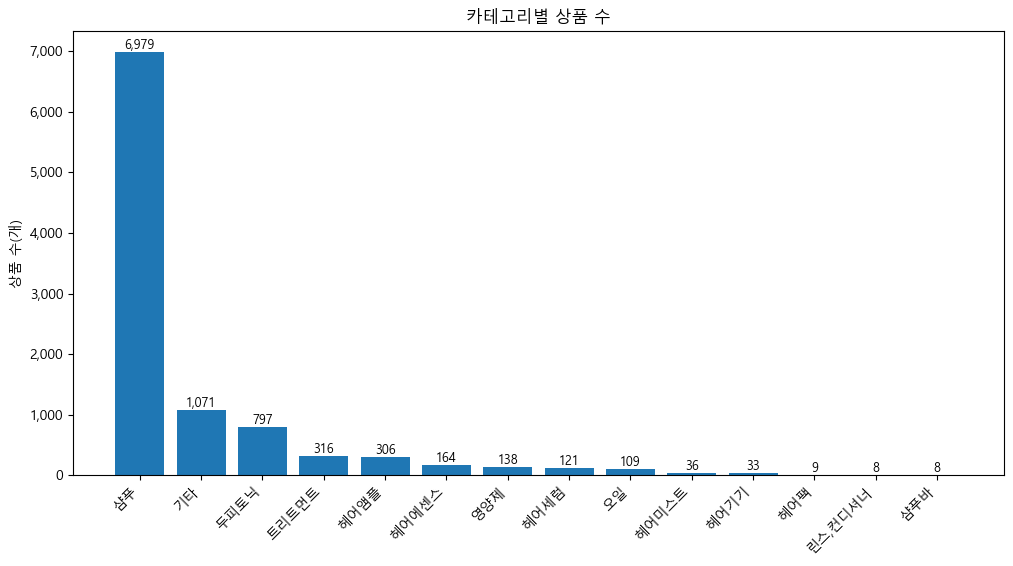

C:\Users\kbjoo\AppData\Local\Temp\ipykernel_53664\1911434478.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=cats, showfliers=False)


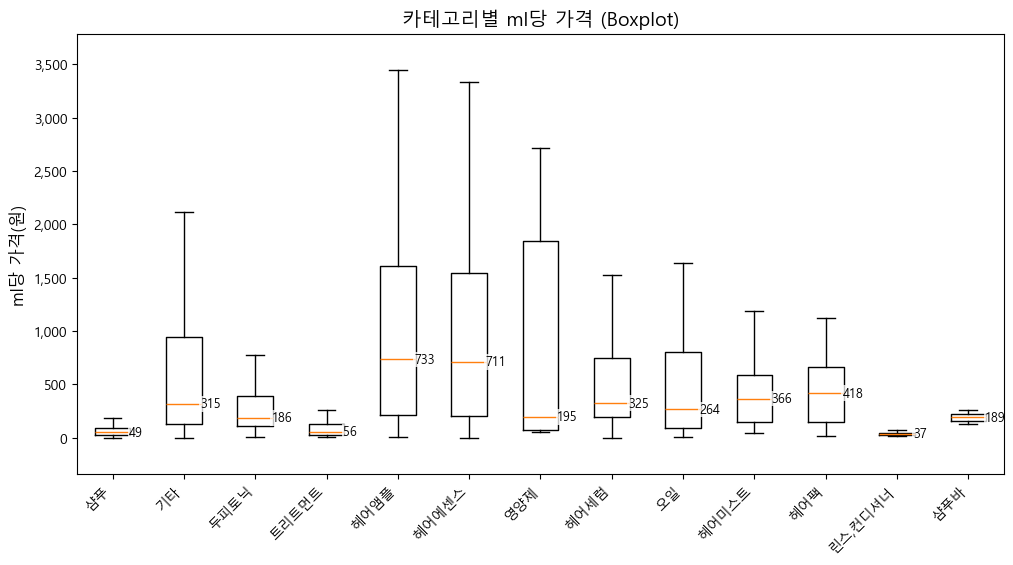

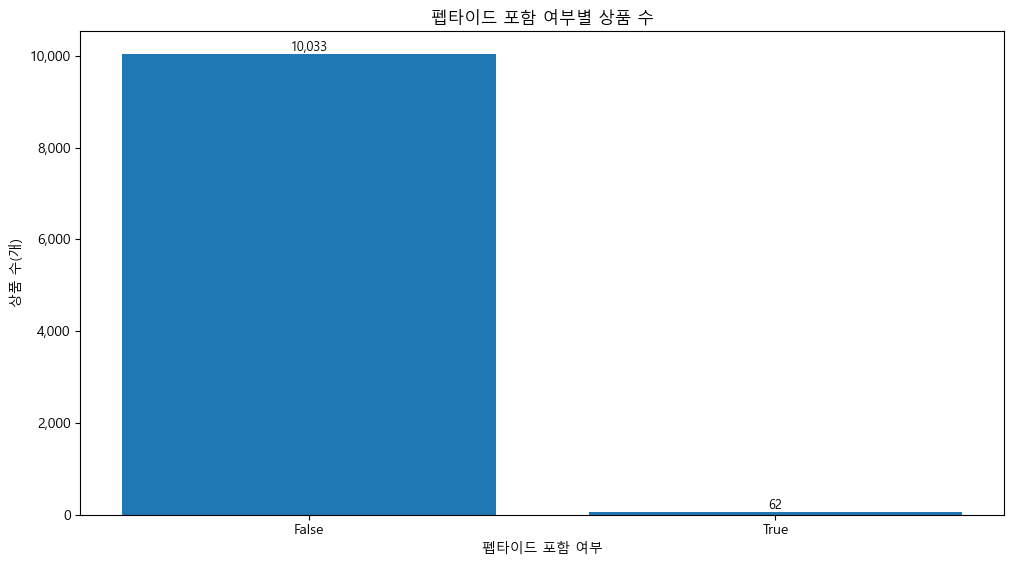

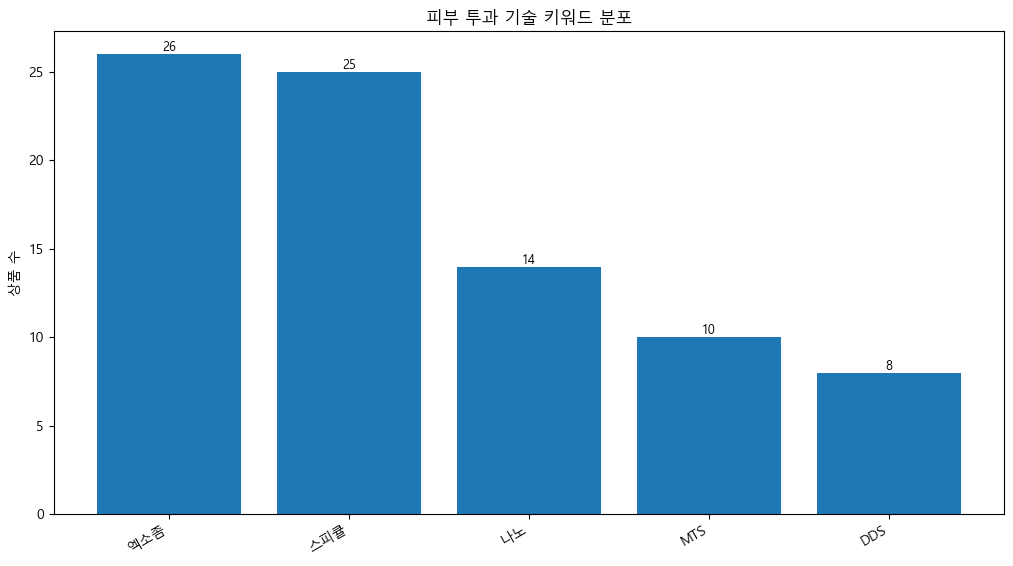

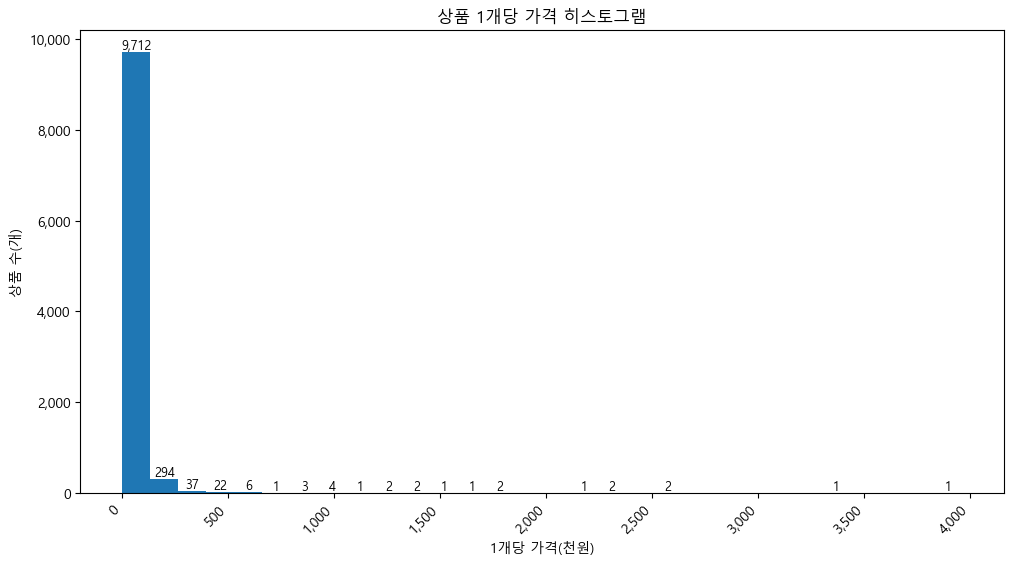

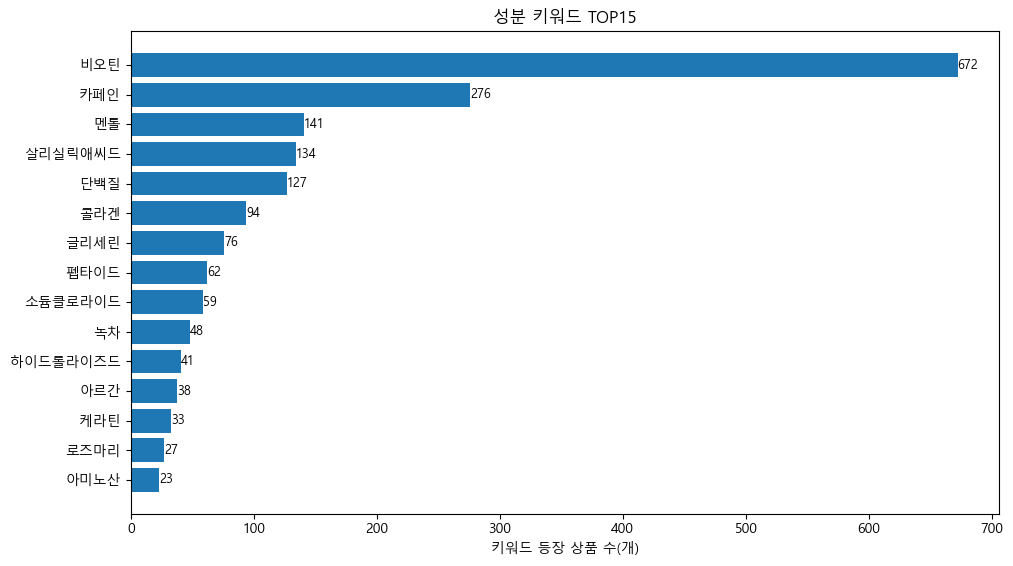

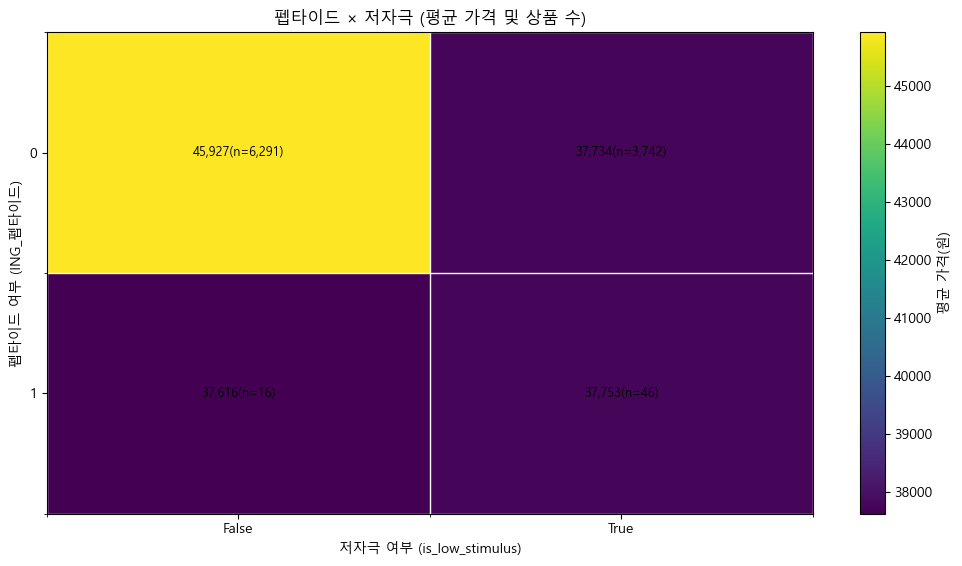

[WindowsPath('out_20251025_123831/chart_category_count_bar.png'),
 WindowsPath('out_20251025_123831/chart_price_per_ml_box.png'),
 WindowsPath('out_20251025_123831/chart_peptide_counts.png'),
 WindowsPath('out_20251025_123831/chart_skin_penetration_keywords.png'),
 WindowsPath('out_20251025_123831/chart_price_per_unit_hist.png'),
 WindowsPath('out_20251025_123831/chart_ingredients_top15.png'),
 WindowsPath('out_20251025_123831/chart_whitespace_matrix.png')]

In [16]:
charts = []
ret = save_category_bar(df, OUTDIR, show=True)
if ret is not None:
    path_bar, category_order = ret
    charts.append(path_bar)
else:
    category_order = None  # bar 차트가 없으면 순서 미고정(fallback 사용)
charts.append( save_price_per_ml_box(df, OUTDIR, show=True, category_order=category_order) )

charts.append(save_peptide_counts_bar(df, OUTDIR, show=True))
charts.append(save_skin_penetration_chart(df, OUTDIR, show=True))

charts.append(save_price_hist(df, OUTDIR, show=True))

charts.append(save_ingredient_bar(df, CFG, OUTDIR, show=True))
charts.append(save_whitespace_matrix(df, OUTDIR, show=True))

charts

### 보고서

In [17]:
report_md = write_markdown_report(OUTDIR, kpis, charts, df)
report_md

WindowsPath('out_20251025_123831/report.md')